In [1]:
import tensorflow as tf
from Dive_into_deep_learning.d2l import tensorflow as d2l

2023-08-09 09:30:37.634650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Implementation from Scratch

In [8]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = [d2l.RNNScratch(num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                     for i in range(num_layers)]
        
    def forward(self, inputs, Hs=None):
        outputs = inputs
        if Hs is None:
            Hs = [None] * self.num_layers
        for i in range(self.num_layers):
            outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
            outputs = tf.stack(outputs, 0) # shape:（num_steps, batch_size, num_hiddens）
        return outputs, Hs

In [13]:
a = tf.convert_to_tensor([[1,2], [3,4], [5, 6]])
b = tf.convert_to_tensor([[7,8], [9,10], [11, 12]])
c =tf.stack([a, b], 0)
d = tf.stack([a, b], 1)

KeyboardInterrupt: 

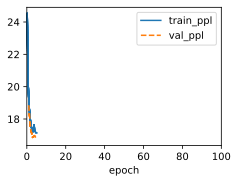

In [9]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
with d2l.try_gpu():
    rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                                  num_hiddens=32, num_layers=2)
    model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

# Concise Implementation

In [14]:
class GRU(d2l.RNN):
    """The multi-layer GRU model."""
    def __init__(self, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        gru_cells = [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
                     for _ in range(num_layers)]
        self.rnn = tf.keras.layers.RNN(gru_cells, return_sequences=True, return_state=True, time_major=True)
        
    def forward(self, X, state=None):
        outputs, *state = self.rnn(X, state)
        return outputs, state

SyntaxError: incomplete input (3185033526.py, line 1)

In [ ]:
gru = GRU(num_hiddens=32, num_layers=2)
with d2l.try_gpu():
    model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)